# Comparing ICAs
This notebook compares ICAs on synthetic and real data. The advantage of syntheticv data is we cna know exactly what happens as we mixed the original componenets.

In [1]:
import copy
import math
import collections
from scipy import interpolate as interp
from scipy import signal
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random


In [2]:
# local resurf
# import our library until next release

sys.path.insert(0, '../resurfemg')
import helper_functions as hf
import multi_lead_type as mt
from tmsisdk_lite import Poly5Reader
import config as cf

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


Now we can load synthetic ECGs

In [3]:
loaded_ecg = np.load('../synth_data/synth_ecg_array.npy')
loaded_ecg.shape

(10, 307200)

Now we will make synthetic EMG

In [4]:
emg = cf.simulate_emg_with_occlusions(t_start=0,
                                 t_end=7*60,
                                 emg_sample_rate=2048,   # hertz
                                 rr=22,         # respiratory rate /min
                                 ie_ratio=1/2,  # ratio btw insp + expir phase
                                 tau_mus_up=0.3,
                                 tau_mus_down=0.3,
                                 occs_times_vals=[6*60+5, 6*60+21, 6*60+35])

In [5]:
emg1 = emg[0][:307200]
emg2 = emg[1][:307200]
emg3 = emg[2][:307200]
emg3.shape
emg_stack = np.vstack((emg1,emg2))
emg_stack = np.vstack((emg_stack,emg3))
emg_stack.shape[1]

307200

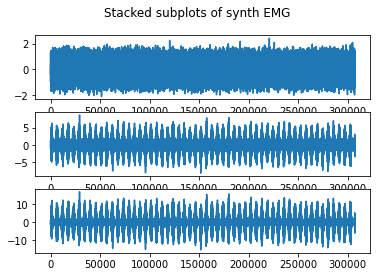

In [6]:
fig, axs = plt.subplots(3)
fig.suptitle('Stacked subplots of synth EMG')
axs[0].plot(emg_stack[0])
axs[1].plot(emg_stack[1])
axs[2].plot(emg_stack[2])

In [7]:
line = random.randint(0, 9)
one_line_ecg = loaded_ecg[line]

In [8]:
x_emg = np.zeros((3,emg_stack.shape[1]))
#x_emg.shape
x_emg[0] = 200*one_line_ecg + 0.05 * emg_stack[0]
x_emg[1] = 200*one_line_ecg + 4 * emg_stack[1]
x_emg[2] = 200*one_line_ecg + 8 * emg_stack[2]

In [9]:
x_emg.shape

(3, 307200)

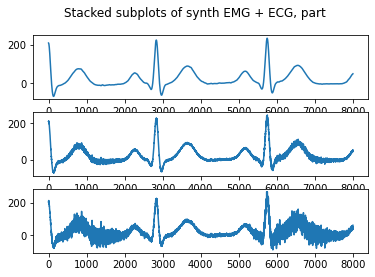

In [10]:
fig, axs = plt.subplots(3)
fig.suptitle('Stacked subplots of synth EMG + ECG, part')
axs[0].plot(x_emg[0][:8000])
axs[1].plot(x_emg[1][:8000])
axs[2].plot(x_emg[2][:8000])


Let's see it all together:

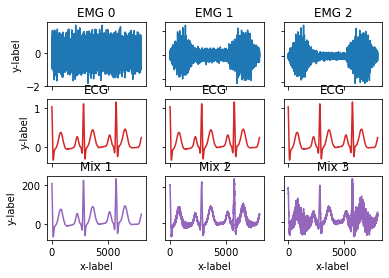

In [11]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(emg_stack[0][:8000])
axs[0, 0].set_title('EMG 0')
axs[0, 1].plot(emg_stack[1][:8000] )
axs[0, 1].set_title('EMG 1')
axs[0, 2].plot(emg_stack[2][:8000])
axs[0, 2].set_title('EMG 2')
axs[1, 0].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 1].set_title('ECG')
axs[1, 2].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 2].set_title('ECG')
axs[2, 0].plot(x_emg[0][:8000], 'tab:purple')
axs[2, 0].set_title('Mix 1')
axs[2, 1].plot(x_emg[1][:8000], 'tab:purple')
axs[2, 1].set_title('Mix 2')
axs[2, 2].plot(x_emg[2][:8000], 'tab:purple')
axs[2, 2].set_title('Mix 3')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Let's get amplitude differences

In [43]:

emg_amplitide_lead0 = emg_stack[0][:8000].max() - emg_stack[0][:8000].min()
emg_amplitide_lead1 = emg_stack[1][:8000].max() - emg_stack[1][:8000].min()
emg_amplitide_lead2 = emg_stack[2][:8000].max() - emg_stack[2][:8000].min()
eCg_amplitide_lead0 = one_line_ecg[:8000].max() - one_line_ecg.min()
eCg_amplitide_lead1 = one_line_ecg[:8000].max() - one_line_ecg.min()
eCg_amplitide_lead2 = one_line_ecg[:8000].max() - one_line_ecg.min()

In [44]:

print("EMG lead amplitudes:", emg_amplitide_lead0, emg_amplitide_lead1, emg_amplitide_lead2)
print("EcG lead amplitudes:", eCg_amplitide_lead0, eCg_amplitide_lead1, eCg_amplitide_lead2)

EMG lead amplitudes: 3.572111081984457 12.020736705295906 22.744505175047067
EcG lead amplitudes: 1.5693726087881 1.5693726087881 1.5693726087881


But now let's remember we multiply the ECG these by a certain number i.e. 200 when we do the mixing. 

Now we can run different ICAs over our data and see if different ICAs are in fact different, and how they compare.
Warning: these functions take a really long time to run.

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Text(0.5, 1.0, 'EMGish')

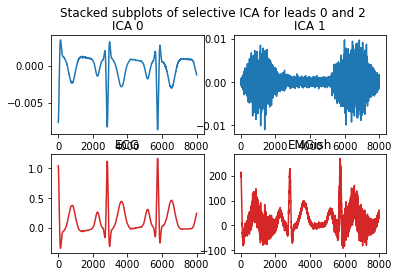

In [13]:
selective_ica = mt.compute_ICA_two_comp_selective(
    x_emg,
    use_all_leads=False,
    desired_leads=(0, 2),
)
#fig, axs = plt.subplots(2)
# fig.suptitle('Stacked subplots of selective ICA for leads 0 and 2')
# axs[0].plot(selective_ica[0][:10000])
# axs[1].plot(selective_ica[1][:10000])

fig, axs = plt.subplots(2, 2)
fig.suptitle('Stacked subplots of selective ICA for leads 0 and 2')
axs[0, 0].plot(selective_ica[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(selective_ica[1][:8000] )
axs[0, 1].set_title('ICA 1')

axs[1, 0].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(x_emg[2][:8000], 'tab:red')
axs[1, 1].set_title('EMGish')


C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Text(0.5, 1.0, 'EMGish')

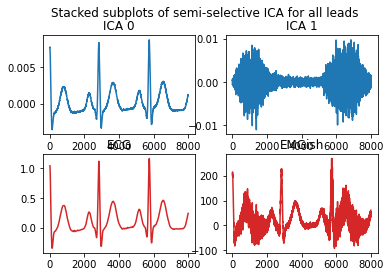

In [14]:
semi_selective_ica = mt.compute_ICA_two_comp_selective(
    x_emg,
    use_all_leads=True,
)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Stacked subplots of semi-selective ICA for all leads')
axs[0, 0].plot(semi_selective_ica[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(semi_selective_ica[1][:8000] )
axs[0, 1].set_title('ICA 1')

axs[1, 0].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(x_emg[2][:8000], 'tab:red')
axs[1, 1].set_title('EMGish')

Observation: when we don't select the most extreme leads we get worse results (notice our ecg-found is more shaky/contaminated). Also notice our amplitudes are not good. Not surprising. Moving on,.

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Text(0.5, 1.0, 'difference from original EMG after scaling')

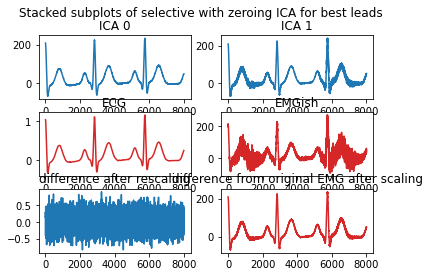

In [48]:
zerod_ica = mt.compute_ICA_n_comp_selective_zeroing(
    x_emg,
    use_all_leads=True,
    #desired_leads=(0, 2),
    lead_to_remove= 0,
)
fig, axs = plt.subplots(3, 2)
fig.suptitle('Stacked subplots of selective with zeroing ICA for best leads')
axs[0, 0].plot(zerod_ica[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(zerod_ica[1][:8000] )
axs[0, 1].set_title('ICA 1')
axs[2, 0].plot(zerod_ica[0][:8000] - 200*one_line_ecg[:8000])
axs[2, 0].set_title('difference after rescaling')
axs[1, 0].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(x_emg[2][:8000], 'tab:red')
axs[1, 1].set_title('EMGish')
axs[2, 1].plot(zerod_ica[1][:8000] - emg_stack[2][:8000], 'tab:red')
axs[2, 1].set_title('difference from original EMG after scaling')

Observation: that was a bad idea. This was actuallty a worse result in multiple ways, including the way amplutes compare except that we get the right amplitude back. Interesting that Maybe we need to zero something else as RW suggests. I hope his algorithm also returns the right amplitude but has better results. 

Let's see what happens if we take out the other lead instead

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Text(0.5, 1.0, 'difference from original EMG after scaling')

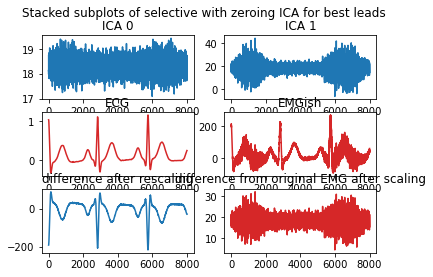

In [49]:
zerod_ica_2 = mt.compute_ICA_n_comp_selective_zeroing(
    x_emg,
    use_all_leads=True,
    #desired_leads=(0, 2),
    lead_to_remove= 2,
)
fig, axs = plt.subplots(3, 2)
fig.suptitle('Stacked subplots of selective with zeroing ICA for best leads')
axs[0, 0].plot(zerod_ica_2[0][:8000])
axs[0, 0].set_title('ICA 0')
axs[0, 1].plot(zerod_ica_2[1][:8000] )
axs[0, 1].set_title('ICA 1')
axs[2, 0].plot(zerod_ica_2[0][:8000] - 200*one_line_ecg[:8000])
axs[2, 0].set_title('difference after rescaling')
axs[1, 0].plot(one_line_ecg[:8000], 'tab:red')
axs[1, 0].set_title('ECG')
axs[1, 1].plot(x_emg[2][:8000], 'tab:red')
axs[1, 1].set_title('EMGish')
axs[2, 1].plot(zerod_ica_2[1][:8000] - emg_stack[2][:8000], 'tab:red')
axs[2, 1].set_title('difference from original EMG after scaling')

Well the amplitudes are wrong, but we get a better shape on the (EMG) lead we want? For scientists to consider.